In [2]:
! pip install ucimlrep

ERROR: Could not find a version that satisfies the requirement ucimlrep (from versions: none)

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for ucimlrep


In [3]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from ucimlrepo import fetch_ucirepo

In [4]:
# load the dataset
air_quality=fetch_ucirepo(id=360)


In [5]:
# Check the dataset
print(air_quality)

{'data': {'ids': None, 'features':            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     3/10/2004  18:00:00     2.6         1360       150      11.9   
1     3/10/2004  19:00:00     2.0         1292       112       9.4   
2     3/10/2004  20:00:00     2.2         1402        88       9.0   
3     3/10/2004  21:00:00     2.2         1376        80       9.2   
4     3/10/2004  22:00:00     1.6         1272        51       6.5   
...         ...       ...     ...          ...       ...       ...   
9352   4/4/2005  10:00:00     3.1         1314      -200      13.5   
9353   4/4/2005  11:00:00     2.4         1163      -200      11.4   
9354   4/4/2005  12:00:00     2.4         1142      -200      12.4   
9355   4/4/2005  13:00:00     2.1         1003      -200       9.5   
9356   4/4/2005  14:00:00     2.2         1071      -200      11.9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0              1046      166          1056      113    

In [6]:
# Convert into dataframes
df=air_quality.data.features

In [7]:
# Select the specific columns for anomaly detection
features=df[['CO(GT)','C6H6(GT)','NOx(GT)','NO2(GT)']]
# These features are used to check air Quality

In [8]:
# Check for missing values 
features.isnull().sum()

CO(GT)      0
C6H6(GT)    0
NOx(GT)     0
NO2(GT)     0
dtype: int64

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CO(GT)    9357 non-null   float64
 1   C6H6(GT)  9357 non-null   float64
 2   NOx(GT)   9357 non-null   int64  
 3   NO2(GT)   9357 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 292.5 KB


In [10]:
# Parameters for isolation forest 
n_estimators=100 # number of trees in the forest
contimation=0.01 # Production of outliers in the data
sample_size=256 # number of samples to draw from the data to train each tree


In [11]:
# train the isolation forest
model=IsolationForest(n_estimators=n_estimators,contamination=contimation,max_samples=sample_size,random_state=42)

model.fit(features)

#pedict anomalies
anomaly_labels=model.predict(features)
#-1 for anomalies , 1 for normal instances
anomaly_labels

array([1, 1, 1, ..., 1, 1, 1])

In [12]:
# Create new column in the original dataset to store anomaly labels
features['anomaly']=anomaly_labels
features.head()

C:\Users\sreej\AppData\Local\Temp\ipykernel_20052\1781416063.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CO(GT),C6H6(GT),NOx(GT),NO2(GT),anomaly
0,2.6,11.9,166,113,1
1,2.0,9.4,103,92,1
2,2.2,9.0,131,114,1
3,2.2,9.2,172,122,1
4,1.6,6.5,131,116,1


In [13]:
features['anomaly'].value_counts()

anomaly
 1    9263
-1      94
Name: count, dtype: int64

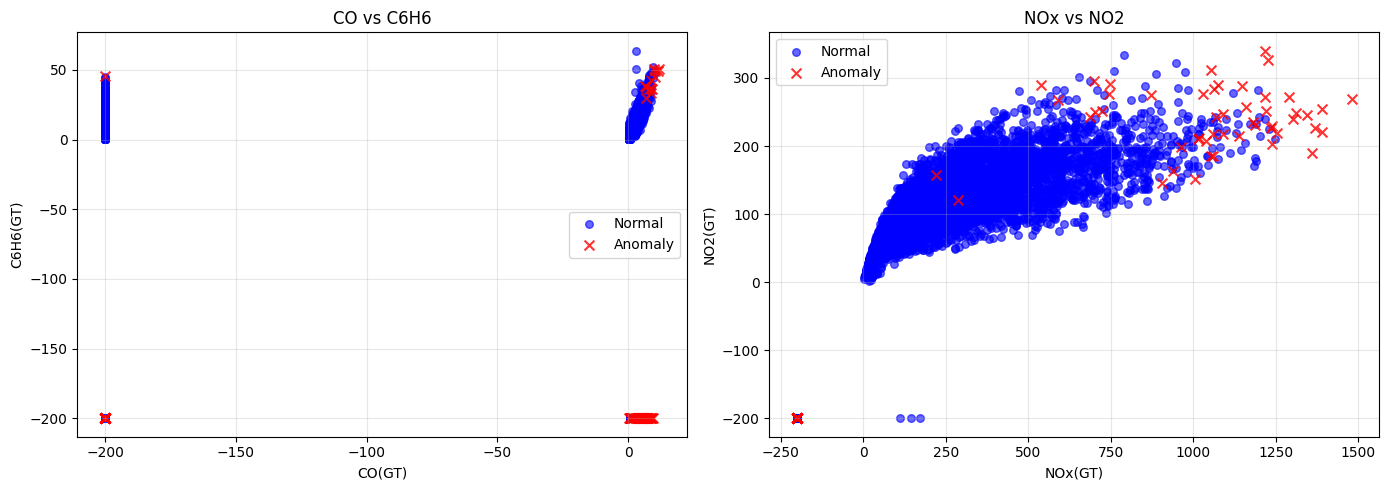

Normal data points: 9263
Anomalies detected: 94


In [14]:
# Visualize anomalies - Multiple feature comparisons
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
 
normal = features[features['anomaly'] == 1]
anomaly = features[features['anomaly'] == -1]
 
# Plot 1: CO vs C6H6
axes[0].scatter(normal['CO(GT)'], normal['C6H6(GT)'], color='blue', label='Normal', alpha=0.6, s=30)
axes[0].scatter(anomaly['CO(GT)'], anomaly['C6H6(GT)'], color='red', label='Anomaly', alpha=0.8, s=50, marker='x')
axes[0].set_xlabel('CO(GT)')
axes[0].set_ylabel('C6H6(GT)')
axes[0].set_title('CO vs C6H6')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
 
# Plot 2: NOx vs NO2
axes[1].scatter(normal['NOx(GT)'], normal['NO2(GT)'], color='blue', label='Normal', alpha=0.6, s=30)
axes[1].scatter(anomaly['NOx(GT)'], anomaly['NO2(GT)'], color='red', label='Anomaly', alpha=0.8, s=50, marker='x')
axes[1].set_xlabel('NOx(GT)')
axes[1].set_ylabel('NO2(GT)')
axes[1].set_title('NOx vs NO2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
 
plt.tight_layout()
plt.show()
 
print(f"Normal data points: {len(normal)}")
print(f"Anomalies detected: {len(anomaly)}")
 

In [22]:
import plotly.graph_objects as go
import numpy as np
 
# Separate normal and anomaly
normal = features[features['anomaly'] == 1]
anomaly = features[features['anomaly'] == -1]
 
fig = go.Figure()
 
# Normal points
fig.add_trace(go.Scatter3d(
    x=normal['CO(GT)'],
    y=normal['C6H6(GT)'],
    z=normal['NOx(GT)'],
    mode='markers',
    name='Normal',
    marker=dict(
        size=6,
        color=normal['NO2(GT)'],   # 4th dimension as color
        colorscale='Blues',
        opacity=0.6,
        colorbar=dict(title='NO2(GT)')
    )
))
 
# Anomaly points
fig.add_trace(go.Scatter3d(
    x=anomaly['CO(GT)'],
    y=anomaly['C6H6(GT)'],
    z=anomaly['NOx(GT)'],
    mode='markers',
    name='Anomaly',
    marker=dict(
        size=8,
        color=anomaly['NO2(GT)'],
        colorscale='Reds',
        opacity=0.9,
        symbol='diamond'
    )
))
 
# Layout
fig.update_layout(
    title='4D Scatter Plot (Color = NO2(GT))',
    scene=dict(
        xaxis_title='CO(GT)',
        yaxis_title='C6H6(GT)',
        zaxis_title='NOx(GT)'
    ),
    width=900,
    height=700
)
 
fig.show()